In [5]:
!pip install gradio
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr


Defaulting to user installation because normal site-packages is not writeable


In [9]:
dataset_dir = r"C:\Users\91914\Downloads\new_dataset\us this data"
image_size = (124, 124)
batch_size = 32
seed = 42

In [29]:
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

Found 3600 files belonging to 6 classes.
Using 2880 files for training.


In [30]:
val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

Found 3600 files belonging to 6 classes.
Using 720 files for validation.


In [12]:
class_names = train_ds.class_names
print("Class names:", class_names)
print("Number of classes:", len(class_names))

Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Number of classes: 6


In [13]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_dat = val_ds.skip(val_batches // 2)

In [31]:
train_ds = train_ds_raw.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_dat_raw.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds_raw.cache().prefetch(tf.data.AUTOTUNE)

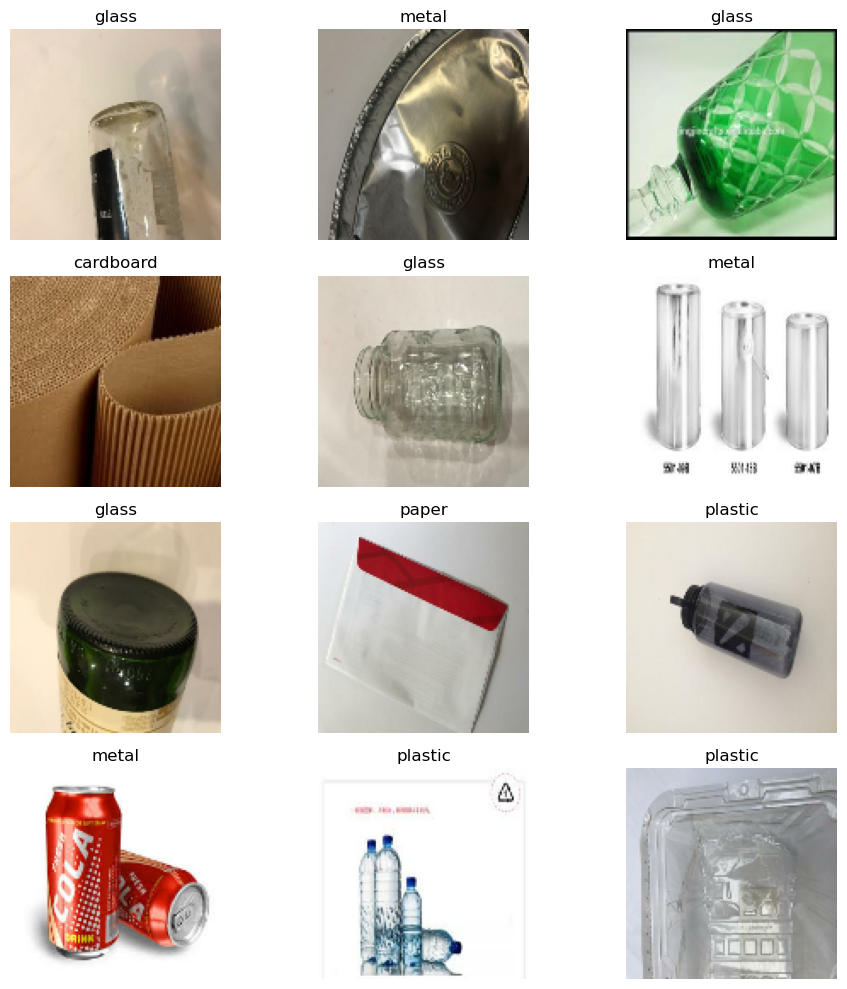

In [33]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [34]:
def count_distribution(dataset, class_names, to_percent=True):
    total = 0
    raw_counts = {name: 0 for name in class_names}
    for _, labels in dataset:
        for label in labels.numpy():
            raw_counts[class_names[label]] += 1
            total += 1
    return {k: round((v / total) * 100, 2) for k, v in raw_counts.items()} if to_percent else raw_counts

In [35]:
def plot_distribution(dist, title="Class Distribution", color="cornflowerblue"):
    plt.figure(figsize=(8, 5))
    bars = plt.bar(dist.keys(), dist.values(), color=color)
    plt.title(title, fontsize=14)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.xlabel("Classes", fontsize=12)
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval}%', ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()

In [36]:
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {k: round((train_dist[k] * 0.8 + val_dist[k] * 0.2), 2) for k in class_names}

print("Train:", train_dist)
print("Validation:", val_dist)
print("Test:", test_dist)
print("Overall:", overall_dist)

Train: {'cardboard': 17.36, 'glass': 16.15, 'metal': 16.6, 'paper': 17.19, 'plastic': 16.6, 'trash': 16.11}
Validation: {'cardboard': 13.59, 'glass': 16.58, 'metal': 18.21, 'paper': 16.3, 'plastic': 17.12, 'trash': 18.21}
Test: {'cardboard': 16.19, 'glass': 19.89, 'metal': 16.48, 'paper': 13.07, 'plastic': 16.19, 'trash': 18.18}
Overall: {'cardboard': 16.61, 'glass': 16.24, 'metal': 16.92, 'paper': 17.01, 'plastic': 16.7, 'trash': 16.53}


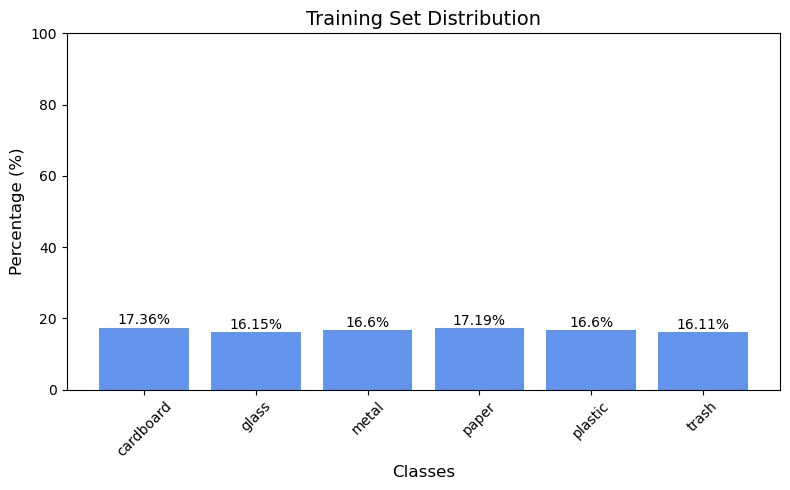

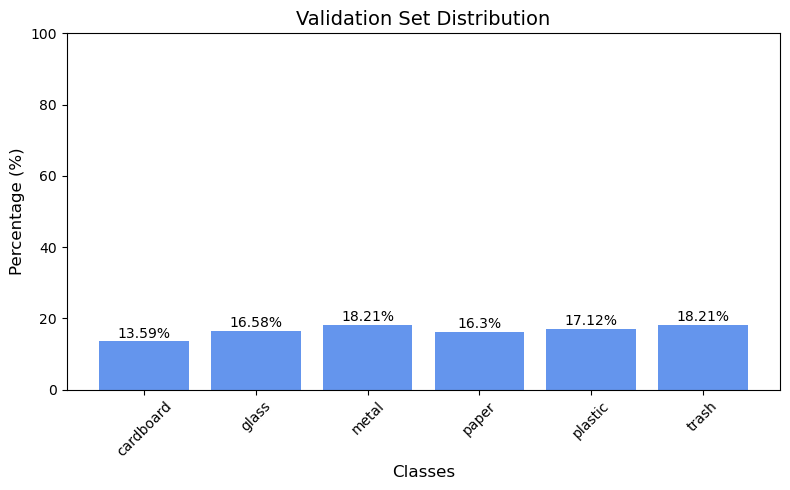

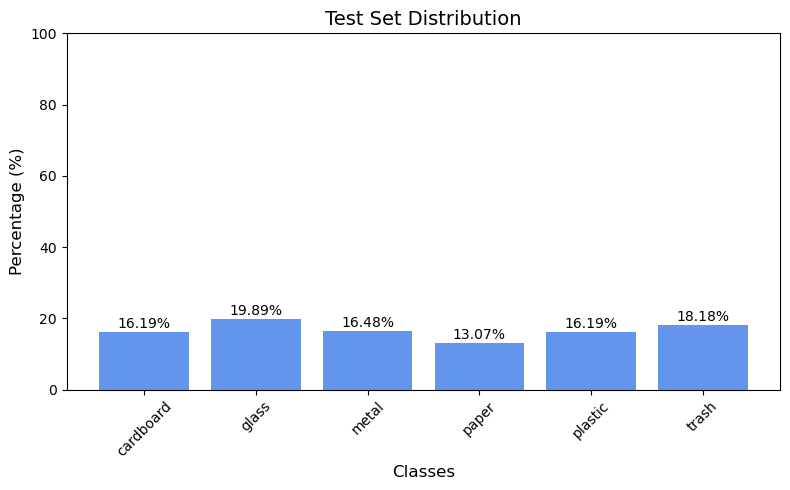

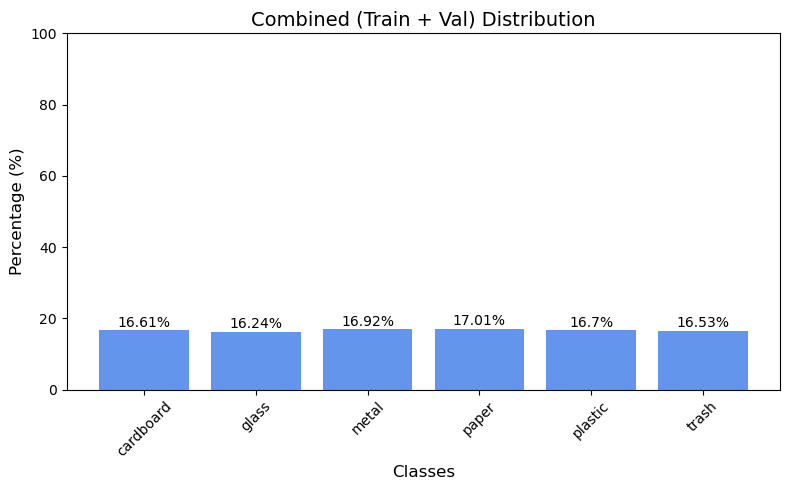

In [37]:
plot_distribution(train_dist, "Training Set Distribution")
plot_distribution(val_dist, "Validation Set Distribution")
plot_distribution(test_dist, "Test Set Distribution")
plot_distribution(overall_dist, "Combined (Train + Val) Distribution")

In [38]:
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for _, labels in train_ds:
    label_batch = labels.numpy()
    for label in label_batch:
        class_counts[label] += 1
        all_labels.append(label)

In [41]:
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 500, 1: 465, 2: 478, 3: 495, 4: 478, 5: 464}
Class Weights: {0: 0.96, 1: 1.032258064516129, 2: 1.00418410041841, 3: 0.9696969696969697, 4: 1.00418410041841, 5: 1.0344827586206897}


In [42]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

In [47]:
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
base_model = EfficientNetV2B2(
    input_shape=(124, 124, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model for transfer learning



In [59]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
], name="richer_augmentation")


In [48]:
model = keras.Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    layers.Lambda(preprocess_input),     # EfficientNet expects preprocessed inputs
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])


In [49]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [60]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-6, verbose=1)
tensorboard = callbacks.TensorBoard(log_dir="./logs")


In [61]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, reduce_lr, tensorboard]
)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.8256 - loss: 0.5809 - val_accuracy: 0.8614 - val_loss: 0.5030 - learning_rate: 1.0000e-04
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.8065 - loss: 0.5723 - val_accuracy: 0.8723 - val_loss: 0.4911 - learning_rate: 1.0000e-04
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.8087 - loss: 0.5844 - val_accuracy: 0.8777 - val_loss: 0.4797 - learning_rate: 1.0000e-04
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.8167 - loss: 0.5590 - val_accuracy: 0.8777 - val_loss: 0.4688 - learning_rate: 1.0000e-04
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.8317 - loss: 0.5412 - val_accuracy: 0.8750 - val_loss: 0.4604 - learning_rate: 1.0000e-04
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.8297 - loss: 0.5279 - val_accuracy: 0.8777 - val_loss: 0.4514 - learning_rate: 1.0000e-04
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.8372 -

In [62]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [64]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [65]:
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, reduce_lr, tensorboard]
)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.8241 - loss: 0.5558 - val_accuracy: 0.8668 - val_loss: 0.4789 - learning_rate: 1.0000e-05
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.8223 - loss: 0.5498 - val_accuracy: 0.8696 - val_loss: 0.4692 - learning_rate: 1.0000e-05
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.8267 - loss: 0.5315 - val_accuracy: 0.8750 - val_loss: 0.4579 - learning_rate: 1.0000e-05
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.8448 - loss: 0.5104 - val_accuracy: 0.8777 - val_loss: 0.4476 - learning_rate: 1.0000e-05
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.8312 - loss: 0.5238 - val_accuracy: 0.8804 - val_loss: 0.4377 - learning_rate: 1.0000e-05


In [66]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, 124, 124, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_2 (Lambda)                    │ (None, 124, 124, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 4, 4, 1408)          │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │           8,454 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,529,538 (43.98 MB)

 Trainable params: 1,375,854 (5.25 MB)

 Non-trainable params: 7,401,974 (28.24 MB)

 Optimizer params: 2,751,710 (10.50 MB)

In [67]:
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 124, 124, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_2 (Rescaling)       │ (None, 124, 124, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_1               │ (None, 124, 124, 3)       │               0 │ rescaling_2[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 62, 62, 32)        │             864 │ normalization_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 62, 62, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 62, 62, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 62, 62, 16)        │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 62, 62, 16)        │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 62, 62, 16)        │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 62, 62, 16)        │           2,304 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 62, 62, 16)        │              64 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 62, 62, 16)        │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 62, 62, 16)        │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 62, 62, 16)        │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 1,367,400 (5.22 MB)

 Non-trainable params: 7,401,974 (28.24 MB)

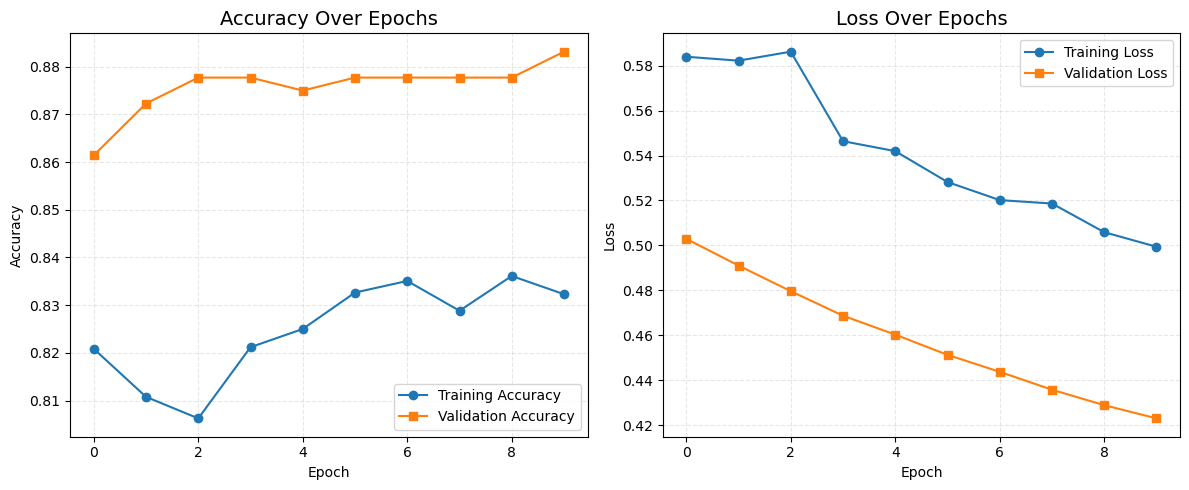

In [68]:
import matplotlib.pyplot as plt
acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
epochs_range = range(len(acc)) 

# Create side-by-side comparison plots
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='s')
plt.title('Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='lower right')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='s')
plt.title('Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [69]:
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print("\n Test Set Evaluation")
print(f" Test Accuracy : {test_accuracy * 100:.2f}%")
print(f" Test Loss     : {test_loss:.4f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 770ms/step - accuracy: 0.9112 - loss: 0.3512

 Test Set Evaluation
 Test Accuracy : 90.06%
 Test Loss     : 0.3798
